In [1]:
import numpy as np
import pandas as pd 


from numpy import array
import torch
from torch import cat, no_grad, manual_seed
import gc
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

#Sklearn
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

manual_seed(444422)

In [2]:
df=pd.read_csv('../datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()
data_shift

,#Passengers
Month,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [3]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label
    
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.fc1 = nn.Linear(12,3)
        self.fc2 = nn.Linear(3,1)
        
    def forward(self,x):
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x
    
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        preds = torch.reshape(preds, (-1,))
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.reshape(preds, (-1,))
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        return valid_loss

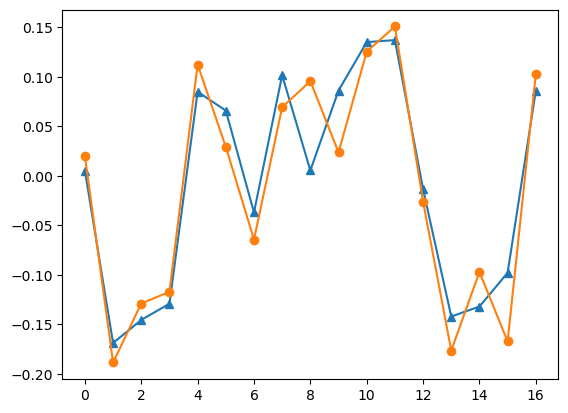

[0.02485233]


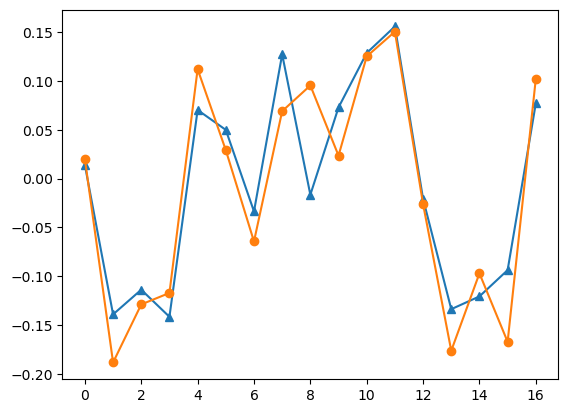

[0.03328008]


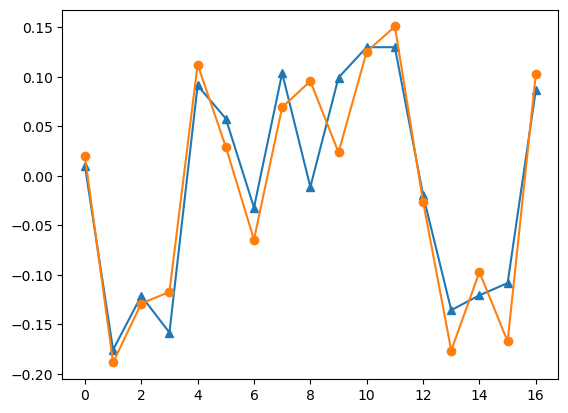

[0.02904738]


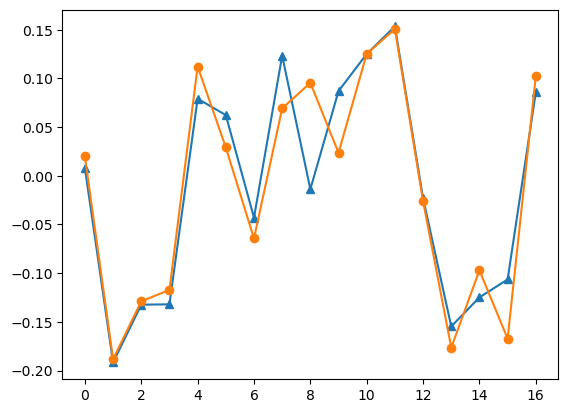

[0.02718097]


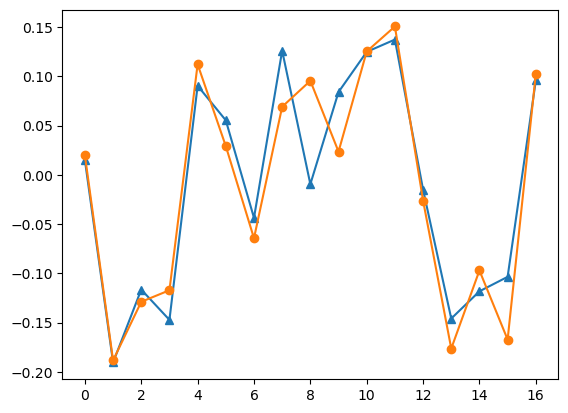

[0.02637651]


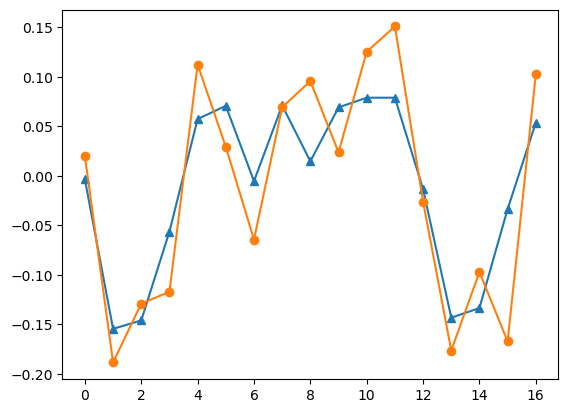

[0.05265851]


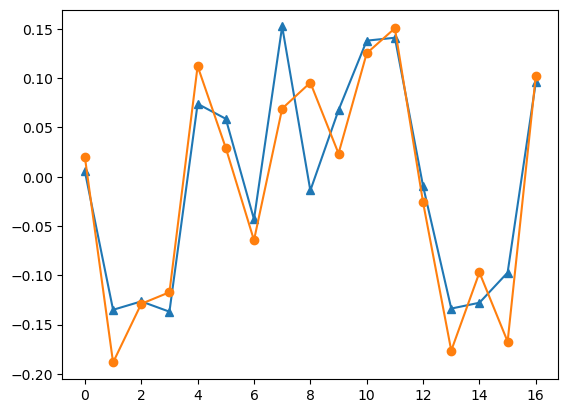

[0.03534754]


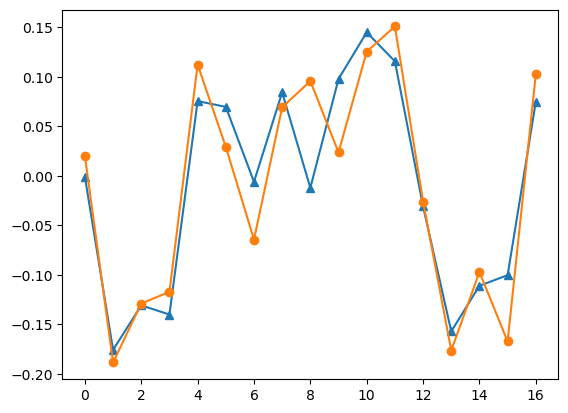

[0.03228484]


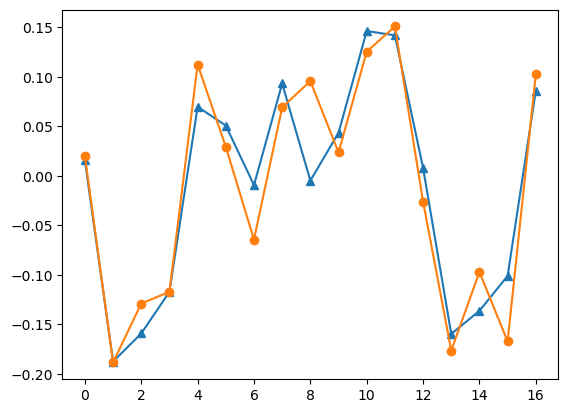

[0.02542305]


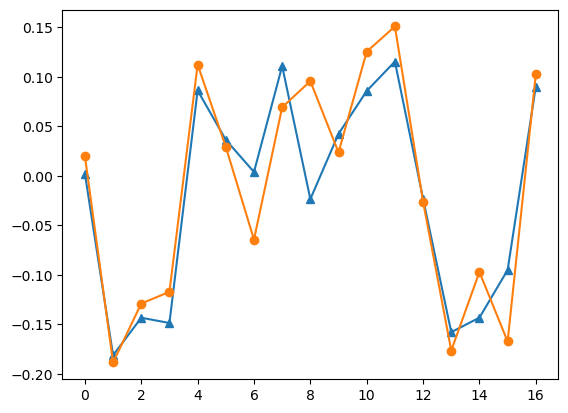

[0.03385842]


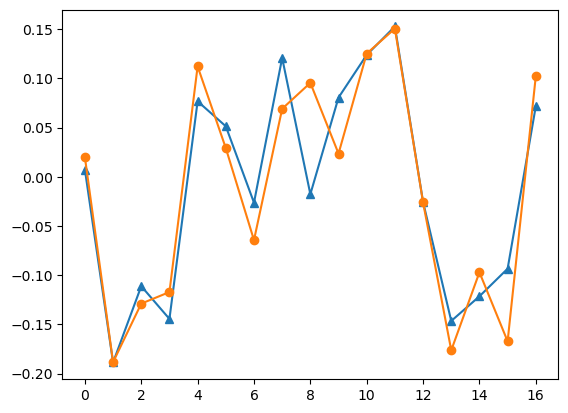

[0.03102868]


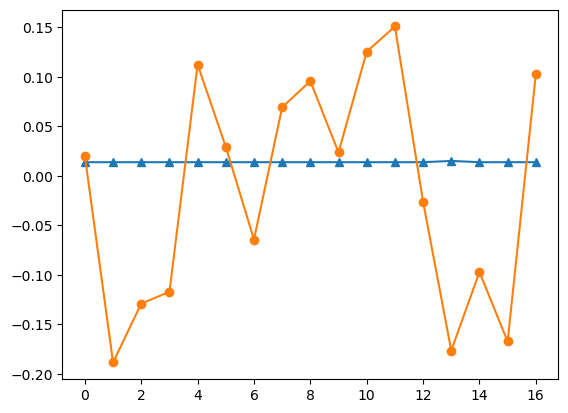

[0.22655785]


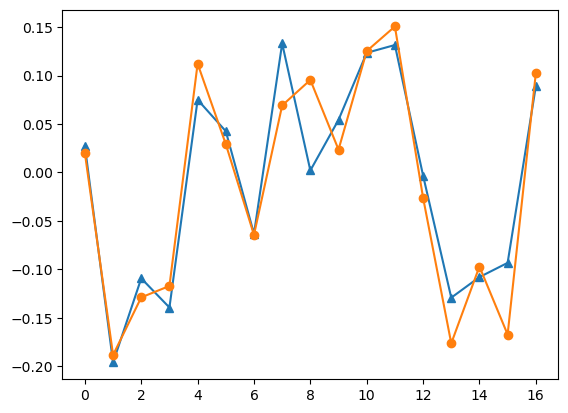

[0.02521537]


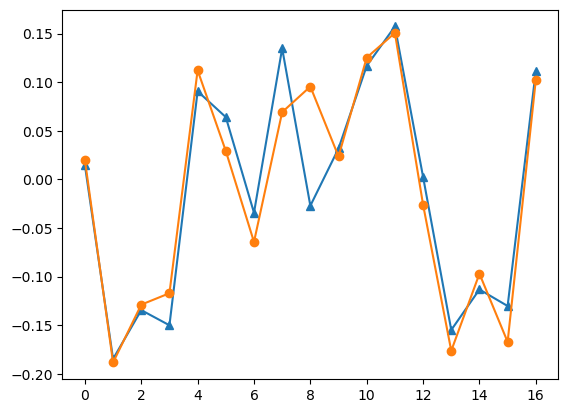

[0.02627013]


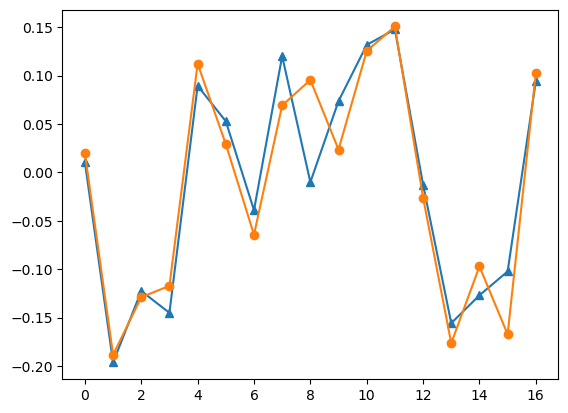

[0.02478012]


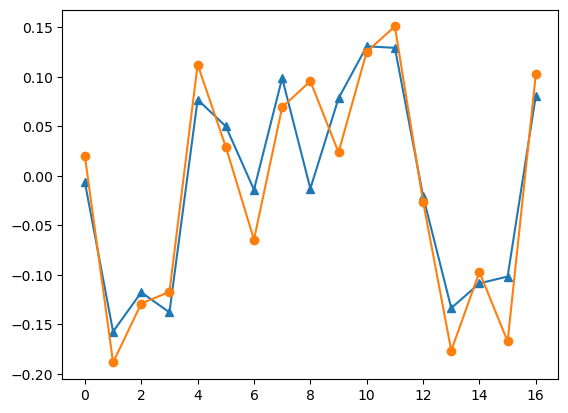

[0.02929458]


In [ ]:
n_estadistico = 30
p_train = 0.8
n_steps = 12

train_losses = []
valid_losses = []
errores_cuadraticos_valid = []

for est in range(n_estadistico):
    
    # Partición de los datos
    train_set = data_shift.iloc[:int(143*0.8)]
    valid_set = data_shift.iloc[int(143*0.8):]
    
    
    train_x,train_y = split_sequence(np.array(train_set['#Passengers']),n_steps)
    valid_x,valid_y = split_sequence(np.array(valid_set['#Passengers']),n_steps)
    
    
    # Creación de los batches
    train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
    valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
    train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

    # Creacion del modelo
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CNN_ForecastNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    
    # Entrenamiento del modelo
    epochs = 200
    for epoch in range(epochs):
        Train()
        loss_valid = Valid()
    
    model.eval()
    
    prediction = []
    inputs = valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)
    
    batch_size = 1
    iterations =  int(inputs.shape[0]/batch_size)

    for i in range(iterations):
        preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
        prediction.append(preds[0].detach().numpy())
    prediction = np.array(prediction)
    
    plt.plot(prediction, marker='^')
    plt.plot(valid_y, marker='o')
    plt.show()
    
    error_cuadratico = 0

    for i in range(len(prediction)):
        error_cuadratico = error_cuadratico + (prediction[i] - valid_y[i])**2
    error_cuadratico/len(prediction)
    
    errores_cuadraticos_valid.append(error_cuadratico)
    print(error_cuadratico)

In [ ]:
print(errores_cuadraticos_valid)